## **TAREA 4: Análisis de Estimaciones de Pobreza Comunal en Chile - 2022**

**Autores:** Simón Ramirez - Victor Saldivia - Carlos Saquel  
**Asignatura:** Visualización de la Información

Este análisis tiene como objetivo explorar las estimaciones de pobreza por ingresos y pobreza multidimensional en las comunas de Chile durante el año 2022. Los datos fueron obtenidos a partir de los conjuntos de datos proporcionados por el Ministerio de Desarrollo Social y Familia de Chile a través del Ministerio de Desarrollo Social y Familia. Se presenta un análisis descriptivo y visualizaciones para comprender de mejor forma las correlaciones y características de la pobreza en las comunas del país.

### **IMPORTACIÓN DE LIBRERÍAS**

In [10]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
from matplotlib import lines
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.collections import PathCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter, MultipleLocator
import matplotlib.gridspec as gridspec
import geopandas as gpd

from mpl_toolkits.axisartist.grid_finder import DictFormatter
import mpl_toolkits.axisartist.floating_axes as floating_axes

import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings("ignore")

### **CARGA DEL DATASET**
El archivo que vamos a utilizar contiene información sobre las estimaciones de pobreza en Chile para el año 2022, tanto de ingresos como multidimensional. 


### **FUNCIONES DE LIMPIEZA DE LOS DATOS**


In [11]:
# Funciones de limpieza de columnas y acentos
def accent_replace(col):
    reemplazos = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
    }
    for acento, sin_acento in reemplazos.items():
        col = col.replace(acento, sin_acento)
    return col

def columns_clean(columnas):
    columnas_limpias = []
    for col in columnas:
        col = accent_replace(col).lower().replace('\n', '')
        col = re.sub(r'\(.*?\)', '', col).replace('*', '').replace(' ', '_')
        col = re.sub(r'[^a-z0-9_]', '', col).rstrip('_')
        columnas_limpias.append(col)
    return columnas_limpias

def get_clean_data(file, get_rows):
    df = pd.read_excel(file, skiprows=get_rows[0])
    df = df.iloc[:get_rows[1]]
    df.columns = columns_clean(df.columns)
    return df

 #### **LIMPIEZA, CARGA Y AJUSTES DE COLUMNAS DEL DATASET DE POBREZA POR INGRESOS**

In [12]:
df_1 = get_clean_data(file='./data/Estimaciones_Tasa_Pobreza_Ingresos_Comunas_2022.xlsx', get_rows=[2, 345])
df_1.columns = ['codigo', 'region', 'comuna', 'poblacion', 'personas_pobreza_por_ingresos', 'porcentaje_pobreza_por_ingresos_2022',
                'limite_inferior_ingreso', 'limite_superior_ingreso', 'presencia_comuna_casen', 'tipo_de_estimacion_sae']

 #### **LIMPIEZA, CARGA Y AJUSTES DE COLUMNAS DEL DATASET DE POBREZA MULTIDIMENSIONAL**

In [13]:
df_2 = get_clean_data(file='./data/Estimaciones_Indice_Pobreza_Multidimensional_Comunas_2022.xlsx', get_rows=[2, 345])
df_2.columns = ['codigo', 'region', 'comuna', 'poblacion', 'personas_pobreza_multidimensional', 'porcentaje_pobreza_multidimensional_2022',
                'limite_inferior_multidimensional', 'limite_superior_multidimensional', 'presencia_comuna_casen', 'tipo_de_estimacion_sae']

### **COMBINACIÓN DE DATASETS**

In [14]:
df_merge = df_1.merge(df_2[['codigo', 'porcentaje_pobreza_multidimensional_2022', 'limite_inferior_multidimensional', 'limite_superior_multidimensional']], on='codigo')

In [15]:
# Info de + datyos comunales
# para revisar relaciones de densidad de poblacion, latitud y longitud
# estas ultimas estan corregidas repecto de santiago para ver si hay alguna relacion entre distancia a santiago
df_dist = pd.read_csv('https://raw.githubusercontent.com/altazor-1967/Comunas-de-Chile/refs/heads/master/Latitud%20-%20Longitud%20Chile.csv')
df_dist.columns = ['codigo', 'comuna', 'provincia', 'región', 'superficie', 'población', 'densidad', 'IDH 2005', 'latitud', 'longitud', 'latitud (Sexagesimal)', 'longitud (Sexagesimal)']
df_dist.superficie = df_dist.superficie.str.strip().str.replace(',','').astype(float)
df_merge_2 = df_merge.merge(df_dist, on='codigo')
df_merge_2['densidad_pob_2022'] = df_merge_2['poblacion'] / df_merge_2['superficie'].astype(float)

comunas = gpd.read_file('./Comunas/comunas.shp')
comunas = comunas.merge(df_merge_2, left_on='cod_comuna', right_on='codigo')
comunas['densidad_pob_2022_log'] = comunas['densidad_pob_2022'].apply(np.log1p)
comunas['poblacion_log'] = comunas['poblacion'].apply(np.log1p)

In [16]:
regiones_sort = {'Arica y Parinacota': 1, 'Tarapacá': 2, 'Antofagasta': 3, 'Atacama': 4, 'Coquimbo': 5, 'Valparaíso': 6, 'Metropolitana': 7, " O'Higgins": 8, 
                'Maule': 9, 'Ñuble': 10, 'Biobío': 11, 'La Araucanía': 12, 'Los Ríos': 13, 'Los Lagos': 14, 'Aysén': 15, 'Magallanes': 16}

df_merge_2['num_region'] = [17-regiones_sort[r] for r in df_merge_2.region]

In [19]:
#Datos del 2020
df_3 = get_clean_data(file='./data/Estimaciones_de_Tasa_de_Pobreza_por_Ingresos_por_Comunas_2020_revisada2022_09.xlsx', get_rows=[2, 345])
df_3 = df_3[['codigo', 'porcentaje_de_personas_en_situacion_de_pobreza_por_ingresos_2020']]
df_3 = df_3.rename(columns={'porcentaje_de_personas_en_situacion_de_pobreza_por_ingresos_2020': 'porcentaje_pobreza_por_ingresos_2020'})
df_merge_3 = df_merge_2.merge(df_3, on='codigo')
df_merge_3['diff_porcentaje_pobreza_por_ingresos'] = df_merge_3['porcentaje_pobreza_por_ingresos_2020'] - df_merge_3['porcentaje_pobreza_por_ingresos_2022']
df_merge_3['porcentaje_pobreza_por_ingresos_sube'] = df_merge_3['diff_porcentaje_pobreza_por_ingresos']<0

In [273]:
def mod_color_op(color, intensidad=1., alpha=1.):
    return (color[0] * intensidad, color[1] * intensidad, color[2] * intensidad, alpha)

col_yellow = (224,177,101,255)
col_green = (0,150,158,255)
col_salmon = (221,109,109,255)
col_wine = (155,97,128,255)
col_black = (3,2,8,255)
col_white = (225,232,234,255)
col_gray_text = (58,84,95,255)
col_gray = (170,190,199,255)
col_gray_dark = (108,135,147,255)

colorSalmon = tuple([i/255 for i in col_salmon])
colorYellow = tuple([i/255 for i in col_yellow])
#colorYellow = mod_color_op(colorYellow, intensidad=0.93, alpha=1.)
colorWine = tuple([i/255 for i in col_wine])
colorGreen = tuple([i/255 for i in col_green])

colorBlack = tuple([i/255 for i in col_black])
colorWhite= tuple([i/255 for i in col_white])
colorGrayText = tuple([i/255 for i in col_gray_text])
colorGray = tuple([i/255 for i in col_gray])
colorGrayDark = tuple([i/255 for i in col_gray_dark])

color_region = {'Metropolitana': colorGreen, 'Valparaíso': colorSalmon, 'Biobío': colorYellow}

In [21]:
# Fuentes
############################################################################################
font_path_latoBlack = 'Lato/Lato-Black.ttf' 
font_path_latoB = 'Lato/Lato-Bold.ttf' 
font_path_latoR = 'Lato/Lato-Regular.ttf'
font_path_latoI = 'Lato/Lato-Italic.ttf'
font_path_noto2 = 'Noto_Sans_Symbols_2/NotoSansSymbols2-Regular.ttf'

prop_latoBlack = fm.FontProperties(fname=font_path_latoBlack)
prop_latoB = fm.FontProperties(fname=font_path_latoB)
prop_latoR = fm.FontProperties(fname=font_path_latoR)
prop_latoI = fm.FontProperties(fname=font_path_latoI)
prop_noto2 = fm.FontProperties(fname=font_path_noto2)

# Colores 
col_black = (3,2,8,255)
col_white = (225,232,234,255)
col_gray_text = (58,84,95,255)
col_gray = (170,190,199,255)
col_gray_dark = (108,135,147,255)

colorBlack = tuple([i/255 for i in col_black])
colorWhite= tuple([i/255 for i in col_white])
colorGrayText = tuple([i/255 for i in col_gray_text])
colorGray = tuple([i/255 for i in col_gray])
colorGrayDark = tuple([i/255 for i in col_gray_dark])

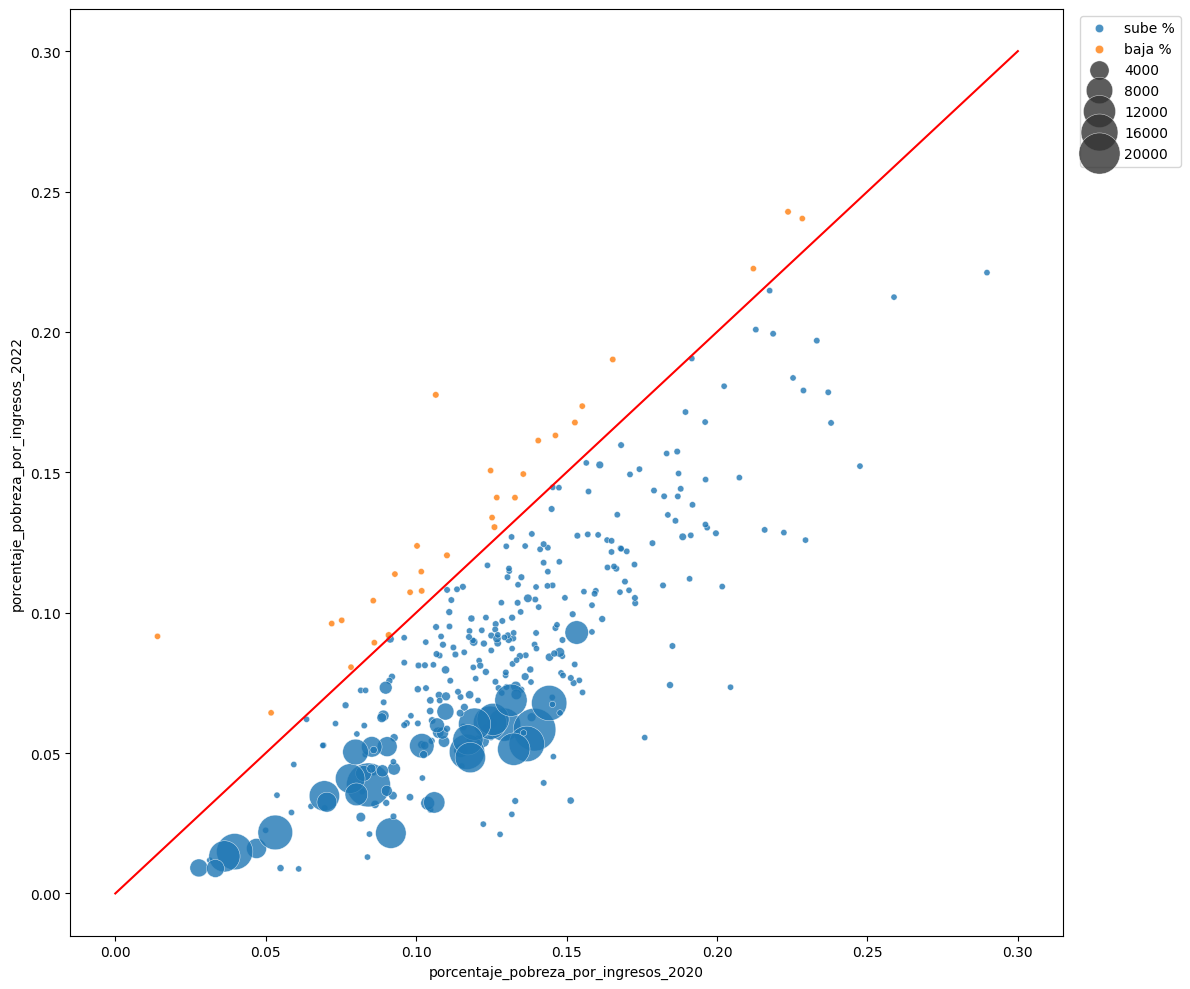

In [22]:
fig, ax = plt.subplots(1, figsize=(12,10))

sns.scatterplot(data=df_merge_3, x='porcentaje_pobreza_por_ingresos_2020', y='porcentaje_pobreza_por_ingresos_2022',
                alpha=0.8, ax=ax, size='densidad_pob_2022', sizes=(20, 1000), marker='o',
                hue=['baja %' if i<0 else 'sube %' for i in df_merge_3['diff_porcentaje_pobreza_por_ingresos']])
ax.plot([0, 0.3], [0, 0.3], color='r')

ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

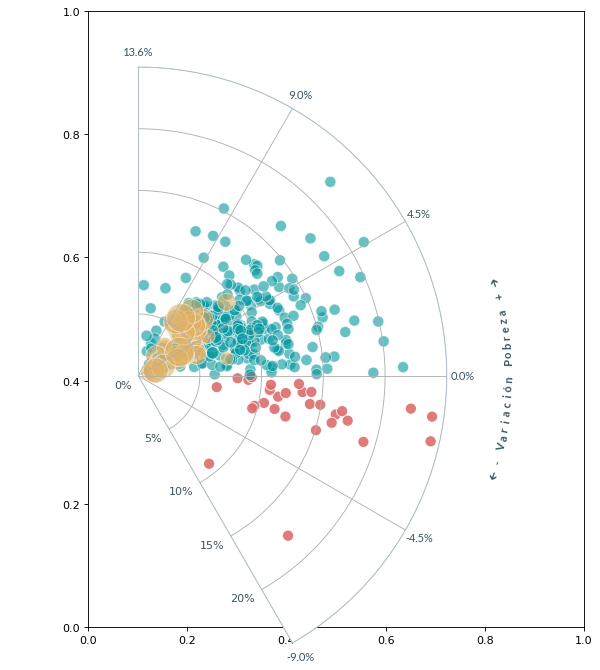

In [278]:
def polarScatter(df, fig, pos=[0.6, 0.85, 0.5, 0.5]):
    polar_ax = fig.add_axes(pos, projection='polar')
    n_adj = 0.48
    df_merge_3_polar = df.copy()
    df_merge_3_polar = df_merge_3_polar.sort_values('densidad_pob_2022', ascending=True)

    beta_ = n_adj*np.pi/df_merge_3_polar['diff_porcentaje_pobreza_por_ingresos'].abs().max()
    sns.scatterplot(x=df_merge_3_polar['diff_porcentaje_pobreza_por_ingresos']*beta_,
                    y=df_merge_3_polar['porcentaje_pobreza_por_ingresos_2022'], 
                    alpha=[0.9 if i<0 else 0.6 for i in df_merge_3_polar['diff_porcentaje_pobreza_por_ingresos']], ax=polar_ax, 
                    size=df_merge_3_polar['densidad_pob_2022'], 
                    sizes=(100, 700), marker='o',
                    hue=['r' if i.diff_porcentaje_pobreza_por_ingresos<0 else 'gray' if i.densidad_pob_2022<1250 else 'blue' for i in df_merge_3_polar.itertuples()],
                    palette=[colorGreen, colorSalmon, colorYellow], legend=False)
    polar_ax.set_thetamin(-60)    # Ángulo mínimo en grados
    polar_ax.set_thetamax(90)  # Ángulo máximo en grados
    polar_ax.set_rmax(0.25)
    for spine in polar_ax.spines.values():
        spine.set_color(colorGray)
    polar_ax.set_ylabel("")
    polar_ax.set_xlabel("")
    polar_ax.set_yticklabels([str(int(100*y))+'%' for y in polar_ax.get_yticks()][:-1], fontproperties=prop_latoR)
    polar_ax.set_xticklabels([str(int(1000*x/beta_)/10)+'%' for x in polar_ax.get_xticks()], fontproperties=prop_latoR)
    polar_ax.xaxis.label.set_color(colorGrayText)
    polar_ax.tick_params(axis='x', colors=colorGrayText)
    polar_ax.tick_params(axis='y', colors=colorGrayText)



    # Especificar el texto y sus propiedades
    text_ = "- Variación Pobreza +"
    radius = 0.3  # Radio donde el texto se ubicará
    angle_start = -2  # Ángulo inicial del arco (en grados, -90 para empezar en la parte inferior del arco)

    # Calcular la posición angular de cada letra
    angle_per_char = 1.3  # Ángulo entre cada letra, ajusta este valor para espaciar las letras
    angles = np.linspace(angle_start, angle_start + angle_per_char * (len(text_) - 1), len(text_))

    # Dibujar el texto en el arco
    for i, (char, angle) in enumerate(zip(text_, angles)):
        # Convertir el ángulo a radianes para que Matplotlib lo entienda
        angle_rad = np.deg2rad(angle)
        # Agregar el texto en la posición correspondiente
        polar_ax.text(angle_rad-0.2, radius, char, rotation=angle+75, rotation_mode='anchor',
                ha='center', va='center', fontsize=10, color=colorGrayText, fontproperties=prop_latoB)
    polar_ax.text(angle_rad-0.16, radius, "🡲", ha='center', va='center', rotation=90+18, 
            fontsize=10, weight=900, rotation_mode='anchor',
            color=colorGrayText, fontproperties=prop_noto2)
    polar_ax.text(angle_rad-0.69, radius, "🡰", ha='center', va='center', rotation=90-18, 
            fontsize=10, weight=900, rotation_mode='anchor',
            color=colorGrayText, fontproperties=prop_noto2)



fig, ax = plt.subplots(1, figsize=(8,10), dpi=80)
polarScatter(df_merge_3, fig, pos=[0.0, 0.0, 0.9, 0.9])

In [182]:
def title_fig(fig, ax, posx_line_title, posy_line_title, color_text, color_line, text,
            lw_line_title, pos_x0_title, pos_y0_title, fontsize=14, fontproperties=prop_latoBlack, linespacing=1):
    fig.add_artist(
        lines.Line2D(posx_line_title, posy_line_title, lw=lw_line_title, 
                    color=color_line, solid_capstyle="butt", 
                    transform=ax.transAxes))
    fig.text(pos_x0_title, pos_y0_title, text,
            ha='left', va='top', fontsize=fontsize, weight=700, 
            color=color_text, fontproperties=fontproperties, linespacing=linespacing)

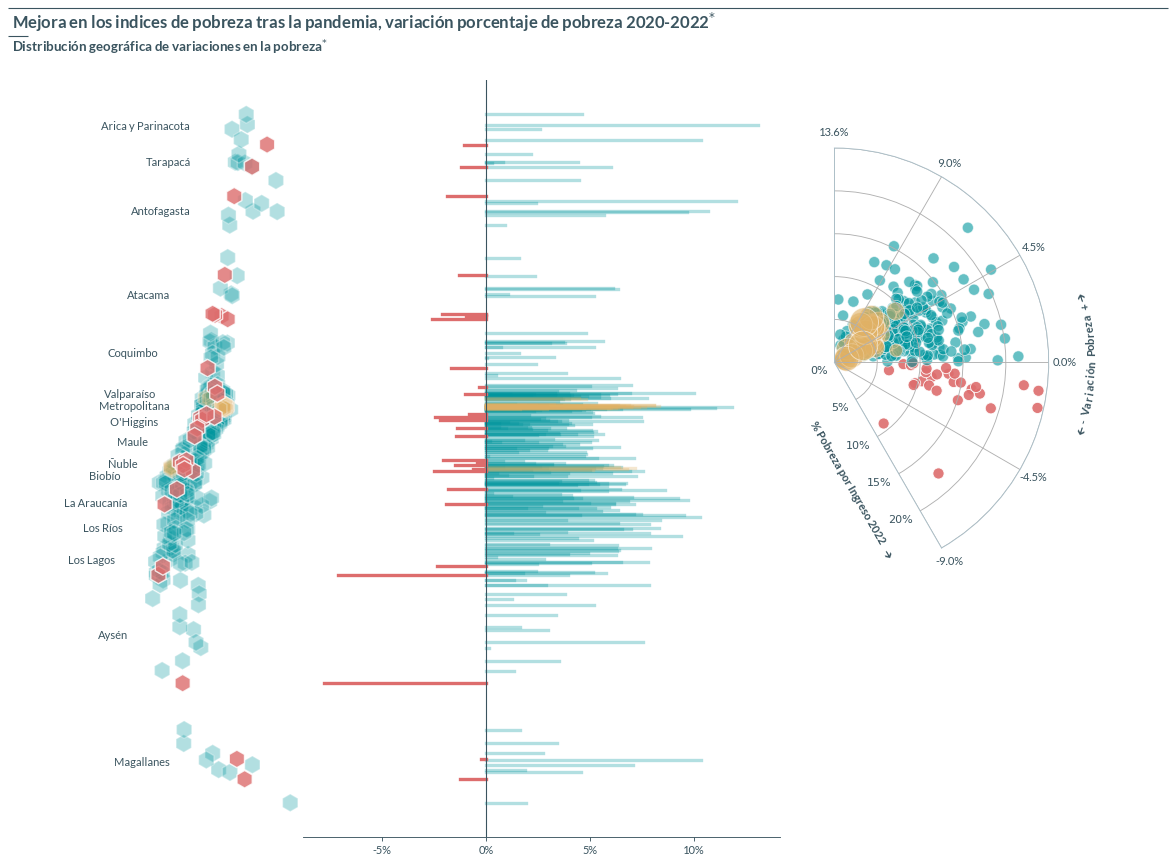

In [282]:
# La subida o baja en el indice no parece tener alguna relación con la distribución geográfica
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10), dpi=80)

fig = plt.figure(figsize=(10,10), dpi=80) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # El primer subplot será el doble de ancho que el segundo
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

n_size=250
diamond_marker = "h"#((0, -0.8), (1.5, 0), (0, 0.8), (-1.5, 0))

df_m_3 = df_merge_3[(df_merge_3['diff_porcentaje_pobreza_por_ingresos']>=0)&(df_merge_3['densidad_pob_2022']<1250)]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=3,
                    color=colorGreen, alpha=0.3, ax=ax2, zorder=1)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='poblacion', sizes=(n_size, n_size), marker=diamond_marker, alpha=0.3, ax=ax1, c=colorGreen, legend=False, zorder=2)


df_m_3 = df_merge_3[(df_merge_3['diff_porcentaje_pobreza_por_ingresos']>=0)&(df_merge_3['densidad_pob_2022']>=1250)]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=3,
                    color=colorYellow, alpha=0.3, ax=ax2, zorder=1)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='poblacion', sizes=(n_size, n_size), marker=diamond_marker, alpha=0.3, ax=ax1, c=colorYellow, legend=False, zorder=2)




df_m_3 = df_merge_3[df_merge_3['diff_porcentaje_pobreza_por_ingresos']<0]
for d in df_m_3.itertuples():
    sns.lineplot(x=[0, d.diff_porcentaje_pobreza_por_ingresos],
                    y=[d.latitud, d.latitud], linewidth=3,
                    color=colorSalmon, alpha=1.0, ax=ax2, zorder=1)
sns.scatterplot(data=df_m_3, 
            x='longitud', y='latitud', size='poblacion', sizes=(n_size, n_size), marker=diamond_marker, alpha=0.8, ax=ax1, c=colorSalmon, legend=False, zorder=2)

ax2.axvline(x=0, color=colorGrayText, linewidth=1, label='', zorder=2)

for d in df_merge_3.sort_values('latitud', ascending=False).groupby('region', as_index=False).median(numeric_only=True).sort_values('latitud', ascending=False).itertuples():
    ax1.text(d.longitud - 2.5, d.latitud, d.region, ha='right', va='center', color=colorGrayText, fontproperties=prop_latoR)

ax1.set_yticks([])
ax1.set_xlim([-76,-65])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='both', which='both', length=0)

pos2 = ax2.get_position()
ax2.set_position([pos2.x0+0.07, pos2.y0, pos2.width, pos2.height])
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.patch.set_facecolor('none')
ax2.set_yticks([])
#ax2.xaxis.set_ticks_position('top')
#ax2.xaxis.set_label_position('top')
ax2.set_xticklabels([str(int(100*x))+'%' for x in ax2.get_xticks()], fontproperties=prop_latoR)
ax2.spines['bottom'].set_color(colorGrayText)
ax2.tick_params(axis='x', colors=colorGrayText)
ax2.xaxis.label.set_color(colorGrayText)


# Polar Scatter
x_=0.87
y_=0.4
polarScatter(df_merge_3.sort_values('densidad_pob_2022', ascending=False), fig, pos=[x_, y_, 0.5, 0.5])

fig.text(x_+0.08, y_+0.16, "% Pobreza por Ingreso 2022", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_latoB, rotation=-60)
fig.text(x_+0.168, y_, "🡲", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_noto2, rotation=-60)

# Titulo
pos_y_ = -0.025
posx_line_title = [-0.05, 1.4+0]
posy_line_title = [1.1+pos_y_, 1.1+pos_y_]
lw_line_title = 1
pos_x0_title = -0.045
pos_y0_title = 1.097+pos_y_
fig.add_artist(
    lines.Line2D(posx_line_title, posy_line_title, lw=1, 
                color=colorGrayText, solid_capstyle="butt", 
                transform=fig.transFigure ))
fig.text(pos_x0_title, pos_y0_title, "Mejora en los indices de pobreza tras la pandemia, variación porcentaje de pobreza 2020-2022$^{*}$",
        ha='left', va='top', fontsize=15, weight=700, 
        color=colorGrayText, fontproperties=prop_latoB, linespacing=1)

pos_y_2 = -0.035
posx_line_title = [-0.05, -0.025]
posy_line_title = [1.1+pos_y_+pos_y_2, 1.1+pos_y_+pos_y_2]
lw_line_title = 1
pos_x0_title = -0.045
pos_y0_title = 1.097+pos_y_+pos_y_2
fig.add_artist(
    lines.Line2D(posx_line_title, posy_line_title, lw=1, 
                color=colorGrayText, solid_capstyle="butt", 
                transform=fig.transFigure ))
fig.text(pos_x0_title, pos_y0_title, "Distribución geográfica de variaciones en la pobreza$^{*}$",
        ha='left', va='top', fontsize=12, weight=700, 
        color=colorGrayText, fontproperties=prop_latoB, linespacing=1)


plt.tight_layout()
plt.show()